Bayesian Optimization with GauOptX: A Practical Guide
================================================================================

Topics Covered:
Getting Started with GauOptX

Installation and setup
Overview of key functionalities
Fundamentals of Bayesian Optimization

Understanding Gaussian Processes
Role of Acquisition Functions
Real-World Applications of Bayesian Optimization
Optimizing a 1D Function

Implementing Bayesian optimization in one dimension
Visualizing the optimization process
Optimizing a 2D Function

Extending Bayesian optimization to higher dimensions
Challenges and strategies in 2D optimization

## 1. How to use GauOptX?

We start by loading GauOptX and GPy.

In [1]:
%pylab inline  
import GPy
import GauOptX
from numpy.random import seed
import matplotlib

Populating the interactive namespace from numpy and matplotlib
warning in stationary: failed to import cython module: falling back to numpy


/Users/gojav/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


warning in stationary: failed to import cython module: falling back to numpy


GauOptX is easy to use as a black-box functions optimizer. To start you only need: 

* Your favorite function $f$ to minimize. We use $f(x)=2x^2$ in this toy example, whose global minimum is at x=0.

In [2]:
def myf(x):
    return (2*x)**2

Defining Box Constraints: In this case, we consider the interval 
[−1,1]......[−1,1]. This can be specified using a list of dictionaries, where each entry outlines the variable’s name, type, and allowable range.

In [3]:
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (-1,1)}]

* A budget, or number of allowed evaluations of $f$.

In [4]:
max_iter = 15

With these three key components, **GauOptX** has all the necessary information to identify the minimum of \( f \) within the specified region. The optimization process in **GauOptX** occurs in two steps. First, a **GauOptX** object must be created to define the problem, including the function \( f \) and the box constraints. This can be achieved as follows...

In [5]:
myProblem = GauOptX.methods.BayesianOptimization(myf,bounds)

Next you need to run the optimization for the given budget of iterations. This bit it is a bit slow because many default options are used. In the next notebooks of this manual you can learn how to change other parameters to optimize the performance.

In [6]:
myProblem.run_optimization(max_iter)

Now you can check the best found location $x^*$ by

In [7]:
myProblem.x_opt

array([-0.01037063])

and the predicted value value of $f$ at $x^*$ optimum by

In [8]:
myProblem.fx_opt

array([ 0.0004302])

That's it! Now, continue reading to explore how **GauOptX** leverages Bayesian Optimization to solve this and other optimization problems. You'll also discover various features and customization options to efficiently tackle your own optimization tasks.

2. The Basics of Bayesian Optimization

Bayesian Optimization (BO) is a strategy for global optimization of black-box functions. Given a Lipschitz continuous function f:X→Rf: \mathcal{X} \to \mathbb{R}, defined on a compact subset X⊆Rd\mathcal{X} \subseteq \mathbb{R}^d, the objective is to solve:

xM=arg⁡min⁡x∈Xf(x)x_{M} = \arg \min_{x \in \mathcal{X}} f(x)Since ff is a black-box function, only noisy observations of the form:

yi=f(xi)+ϵi,whereϵi∼N(0,ψ2)y_i = f(x_i) + \epsilon_i, \quad \text{where} \quad \epsilon_i \sim \mathcal{N}(0, \psi^2)are available. The goal is to select evaluation points x1,…,xNx_1, \dots, x_N such that the cumulative regret

rN=Nf(xM)−∑n=1Nf(xn)r_N= N f(x_{M}) - \sum_{n=1}^N f(x_n)is minimized. A lower rNr_N means we identify xMx_M efficiently.

Key Components of Bayesian Optimization

Prior Probability Model on ff:
A probabilistic model (typically a Gaussian Process) represents our belief about ff.
The model is updated as more observations are collected.
Acquisition Function acqu(x)\text{acqu}(x):
Determines where to sample next based on the current model.
Balances exploration (uncertain areas) and exploitation (promising areas).
At each iteration, the model is updated with new data, and the acquisition function is re-optimized until convergence.

### 2.1 Prior probability meassure on $f$: Gaussian processes

### **Gaussian Processes in Bayesian Optimization**  

A **Gaussian Process (GP)** is a probability distribution over functions, where any finite set of function values follows a **multivariate Gaussian distribution**. GPs are widely used in **Bayesian Optimization** due to their ability to model complex functions with uncertainty estimation.  

A GP is fully specified by:  
1. **Mean function** \( \mu(x) \), which is often assumed to be zero without loss of generality.  
2. **Covariance function (Kernel)** \( k(x, x') \), which determines the smoothness and structure of the function.  

#### **Kernel Function**  
A common choice for the kernel is the **Squared Exponential (SE) Kernel**:  

\[
k(x, x') = l \cdot \exp \left(-\frac{\|x - x'\|^2}{2\sigma^2} \right)
\]

where:  
- \( l \) controls the variance (scaling factor).  
- \( \sigma^2 \) controls the length scale (how far correlations extend).  

This kernel ensures smooth and differentiable function approximations.  

#### **GP Notation**  
If \( f(x) \) is drawn from a Gaussian Process, we write:  

\[
f(x) \sim \mathcal{GP}(\mu(x), k(x, x'))
\]

This means that for any set of points \( X = \{x_1, \dots, x_n\} \), the corresponding function values follow a **multivariate Gaussian distribution**.  

#### **Gaussian Process Regression**  
For function observations \( y = (y_1, \dots, y_n)^T \) at points \( X = \{x_1, \dots, x_n\} \), where:

\[
y_i = f(x_i) + \epsilon_i, \quad \text{with} \quad \epsilon_i \sim \mathcal{N}(0, \sigma^2)
\]

the posterior distribution of \( f(x^*) \) at a new input \( x^* \) is Gaussian:

\[
f(x^*) | X, y, \theta \sim \mathcal{N}(\mu(x^*), \sigma^2(x^*))
\]

where \( \mu(x^*) \) and \( \sigma^2(x^*) \) have closed-form expressions.  

GPs allow Bayesian Optimization to make informed decisions about where to sample next by **balancing exploration and exploitation** using uncertainty estimates from \( \sigma^2(x^*) \).

### **2.2 Acquisition Functions in Bayesian Optimization**  

Acquisition functions help determine where to evaluate next in **Bayesian Optimization** by balancing **exploration** (searching new regions) and **exploitation** (refining known good areas). They represent our belief over the maximum of \( f(x) \) based on previous evaluations.  

Let:  
- \( \theta \) be the parameters of the Gaussian Process (GP) model.  
- \( \{x_i, y_i\} \) be the available dataset of function evaluations.  
- \( f(x_{best}) \) be the best function value observed so far.  
- \( \mu(x) \) and \( \sigma(x) \) be the GP's predictive mean and standard deviation at \( x \).  

#### **Common Acquisition Functions in GauOptX**  

##### **1. Maximum Probability of Improvement (MPI)**  
MPI focuses on selecting points that have the highest probability of improving over the current best observation:  

\[acqu_{MPI}(x;\{x_n,y_n\},\theta) = \Phi(\gamma(x)),\]

where  

\[\gamma(x) = \frac{\mu(x;\{x_n,y_n\},\theta) - f(x_{best}) - \psi}{\sigma(x;\{x_n,y_n\},\theta)}.\]

- \( \Phi(\cdot) \) is the cumulative distribution function (CDF) of the standard normal distribution.  
- \( \psi \) is a small positive parameter to encourage exploration.  

##### **2. Expected Improvement (EI)**  
EI selects points with the highest **expected improvement** over the best observed function value:  

\[
acqu_{EI}(x;\{x_n,y_n\},\theta) = \sigma(x;\{x_n,y_n\},\theta) \cdot (\gamma(x) \Phi(\gamma(x))) + \mathcal{N}(\gamma(x);0,1).
\]

- Encourages exploration in areas with high uncertainty (\( \sigma(x) \)).  
- Exploits areas where the mean prediction \( \mu(x) \) is high.  

##### **3. Upper Confidence Bound (UCB)**  
UCB balances mean function values and uncertainty using a weighted sum:  

\[
acqu_{UCB}(x;\{x_n,y_n\},\theta) = -\mu(x;\{x_n,y_n\},\theta) + \psi \sigma(x;\{x_n,y_n\},\theta).
\]

- **\( \psi \)** controls the balance between exploitation (low \( \psi \)) and exploration (high \( \psi \)).  
- Higher values of \( \psi \) encourage sampling in regions with high uncertainty.  

#### **Exploration vs. Exploitation Trade-Off**  
- **Exploitation:** Focuses on areas where the predicted function value is high.  
- **Exploration:** Seeks areas with high uncertainty to discover better solutions.  
- **Balance:** Tuned using \( \psi \) (in MPI, EI, UCB) and \( \eta \) (in UCB) to adjust how much weight is given to exploration vs. exploitation.  

By selecting appropriate acquisition functions and tuning their parameters, **GauOptX** efficiently finds the global optimum of black-box functions.

## **3. One-Dimensional Example: Forrester Function**  

In this section, we demonstrate how **GauOptX** performs **Bayesian Optimization** on a **one-dimensional** benchmark function known as the **Forrester function**.  

### **3.1 Definition of the Forrester Function**  
The **Forrester function** is defined as:  

\[
f(x) = (6x - 2)^2 \sin(12x - 4)
\]

where \( x \) is constrained to the interval \( [0,1] \).  

- This function is **non-convex** and has a **global minimum** located at:  

  \[
  x_{min} \approx 0.78
  \]

- The Forrester function is widely used in **benchmarking optimization algorithms**, including **Bayesian Optimization**.  

### **3.2 Problem Setup in GauOptX**  
To optimize this function using **Bayesian Optimization**, we need to define:  

1. **The true function** \( f(x) \).  
2. **A noisy (perturbed) version** of \( f(x) \), simulating real-world conditions.  
3. **The search space (boundaries)**, which in this case is \( x \in [0,1] \).  

The following Python code snippet initializes the **GauOptX** optimizer:  

```python
import numpy as np
import matplotlib.pyplot as plt
from gauoptx import GauOptX

# Define the Forrester function
def forrester_function(x):
    return (6 * x - 2) ** 2 * np.sin(12 * x - 4)

# Define the noisy version of the function
def noisy_forrester_function(x):
    noise = np.random.normal(0, 0.1)  # Add Gaussian noise
    return forrester_function(x) + noise

# Define the search space
bounds = [{'name': 'x', 'type': 'continuous', 'domain': (0, 1)}]

# Initialize GauOptX optimizer
optimizer = GauOptX(f=noisy_forrester_function, bounds=bounds)

# Run Bayesian Optimization
optimizer.optimize(n_iter=20)

# Plot the results
optimizer.plot()
plt.show()
```

### **3.3 Explanation of the Code**  
1. **Define the Forrester Function**:  
   - The function \( f(x) \) is implemented as `forrester_function(x)`.  
   - A **noisy** version `noisy_forrester_function(x)` is also created by adding Gaussian noise.  

2. **Define the Search Space**:  
   - `bounds` is a dictionary specifying that \( x \) is a **continuous** variable in the range \( [0,1] \).  

3. **Initialize the Bayesian Optimization Process**:  
   - `GauOptX` is initialized with the function and bounds.  
   - The optimization runs for **20 iterations** (`n_iter=20`).  

4. **Plot the Results**:  
   - The `optimizer.plot()` function visualizes the optimization progress.  

### **3.4 Key Takeaways**  
- **GauOptX** efficiently explores and exploits the function using **Bayesian Optimization**.  
- The optimizer **adapts** to the problem by evaluating uncertain regions while refining promising areas.  
- This example demonstrates how **Gaussian Processes (GPs) and acquisition functions** work together to find the global minimum efficiently.  

This is extended to **higher dimensions** or different objective functions for complex optimization tasks.

In [10]:
%pylab inline  
import GPy
import GauOptX

# Create the true and perturbed Forrester function and the boundaries of the problem
f_true= GauOptX.objective_examples.experiments1d.forrester()          # noisy version
bounds = [{'name': 'var_1', 'type': 'continuous', 'domain': (0,1)}]  # problem constraints 

Populating the interactive namespace from numpy and matplotlib


We plot the true Forrester function.

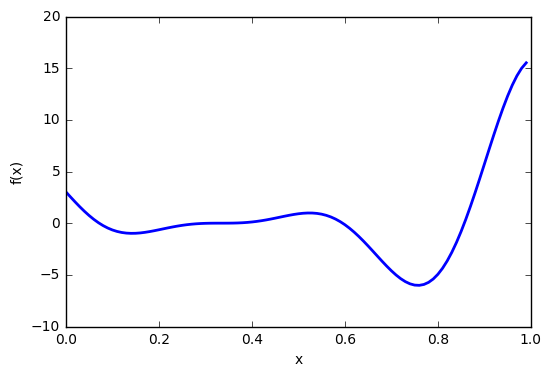

In [11]:
f_true.plot()

Following the approach in Section 3, we now create a GauOptX object and specify:

The objective function (Forrester function with noise).
The boundaries (search space: 
𝑥∈[0,1]
x∈[0,1]).
The acquisition function (e.g., Expected Improvement, EI).

In [12]:
seed(123)
myBopt = GauOptX.methods.BayesianOptimization(f=f_true.f,            # function to optimize       
                                             domain=bounds,        # box-constraints of the problem
                                             acquisition_type='EI',
                                             exact_feval = True) # Selects the Expected improvement

### **3.5 Running the Optimization**  

Once we have defined the **GauOptX** object, we can run the optimization by specifying:  
- The **number of iterations** (`n_iter`).  
- The **acquisition function optimization method**:
  - `acqu_optimize_restart`: Number of local optimizers (random restarts).  
  - `acqu_optimize_method`: Whether to use a **grid search** or **random restarts**.  

### **Explanation of Parameters**  

1. **`n_iter=20`**  
   - Runs **20 iterations** of Bayesian Optimization.  

2. **`acqu_optimize_restart=10`**  
   - Uses **10 random restarts** when optimizing the acquisition function.  
   - Helps avoid getting stuck in local minima.  

3. **`acqu_optimize_method='random'`**  
   - The acquisition function is optimized using **random sampling**.  
   - Alternative: `'grid'` for a **grid-based search**.  

### **Choosing the Acquisition Optimization Method**  
- **Random (`'random'`)**:  
  - Efficient for high-dimensional search spaces.  
  - More exploratory and avoids getting trapped in local optima.  

- **Grid (`'grid'`)**:  
  - Evaluates acquisition function at **fixed points** in the search space.  
  - Works well for low-dimensional problems but is computationally expensive in higher dimensions.  

By selecting the appropriate method and restarts, we **improve the chances** of finding the **global minimum efficiently**.

In [14]:
# Run the optimization
max_iter = 15     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the last two observations

myBopt.run_optimization(max_iter, max_time, eps)                     

After running the Bayesian Optimization process, GauOptX provides a message indicating:

Whether the optimization converged to a solution.
If the maximum number of iterations was reached before convergence.

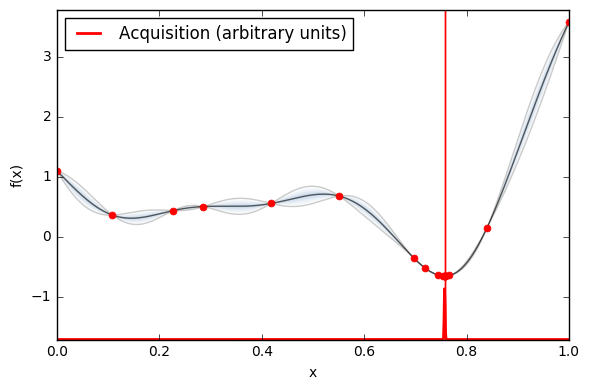

In [15]:
myBopt.plot_acquisition()

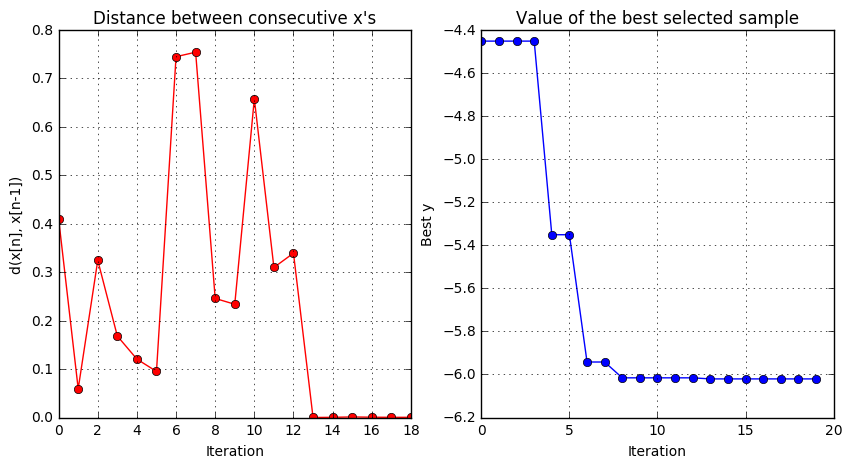

In [16]:
myBopt.plot_convergence()

To analyze the performance of Bayesian Optimization in problems of any dimension, GauOptX provides two key evaluation plots:

1. Distance Between the Last Two Observations
This plot shows how the optimizer selects new points over iterations.
A decreasing trend indicates that the algorithm is refining its search in a smaller region.
If the distance remains high, it suggests more exploration is happening.

2. Best Function Value Over Iterations
This plot tracks the best function value found before each iteration.
Ideally, it should show a decreasing curve, meaning the optimizer is improving the solution.

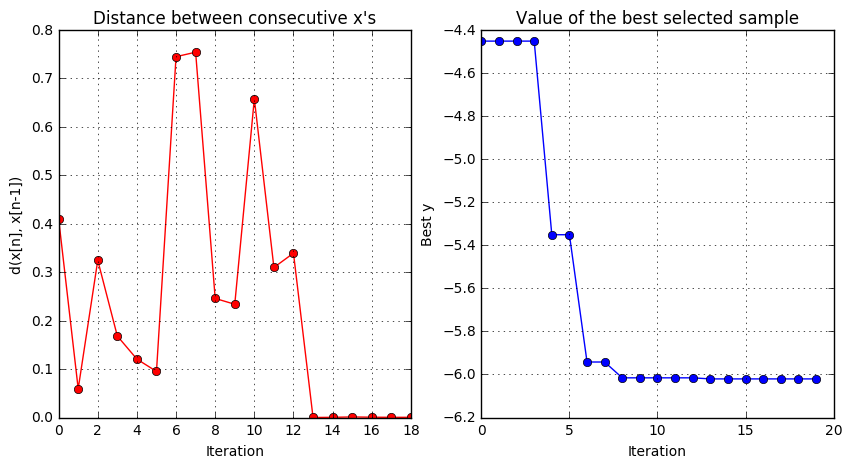

In [17]:
myBopt.plot_convergence()

Now let's make a video to track what the algorithm is doing in each iteration. Let's use the LCB in this case with parameter equal to 2.

## 4. Two dimensional example

Next, we try a 2-dimensional example. In this case we minimize the use the Six-hump camel function 

$$f(x_1,x_2) = \left(4-2.1x_1^2 = \frac{x_1^4}{3} \right)x_1^2 + x_1x_2 + (-4 +4x_2^2)x_2^2,$$

in $[-3,3]\times [-2,2]$. This functions has two global minimum, at $(0.0898,-0.7126)$ and $(-0.0898,0.7126)$. As in the previous case we create the function, which is already in GauOptX. In this case we generate observations of the function perturbed with white noise of $sd=0.1$.

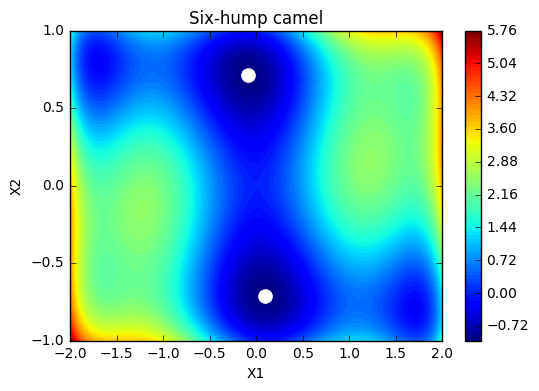

In [18]:
# create the object function
f_true = GauOptX.objective_examples.experiments2d.sixhumpcamel()
f_sim = GauOptX.objective_examples.experiments2d.sixhumpcamel(sd = 0.1)
bounds =[{'name': 'var_1', 'type': 'continuous', 'domain': f_true.bounds[0]},
         {'name': 'var_2', 'type': 'continuous', 'domain': f_true.bounds[1]}]
f_true.plot()

We create the GauOptX object. In this case we use the Lower Confidence bound acquisition function to solve the problem.

In [19]:
# Creates three identical objects that we will later use to compare the optimization strategies 
myBopt2D = GauOptX.methods.BayesianOptimization(f_sim.f,
                                              domain=bounds,
                                              model_type = 'GP',
                                              acquisition_type='EI',  
                                              normalize_Y = True,
                                              acquisition_weight = 2)    

 We run the optimization for 40 iterations and show the evaluation plot and the acquisition function.

In [20]:
# runs the optimization for the three methods
max_iter = 40  # maximum time 40 iterations
max_time = 60  # maximum time 60 seconds

myBopt2D.run_optimization(max_iter,max_time,verbosity=False)            

Finally, we plot the acquisition function and the convergence plot.

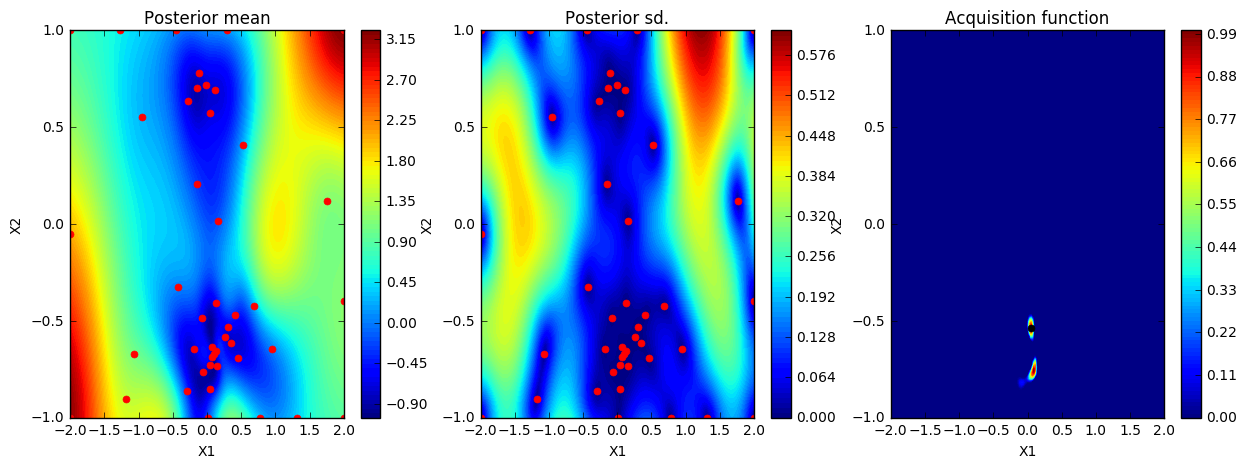

In [21]:
myBopt2D.plot_acquisition() 

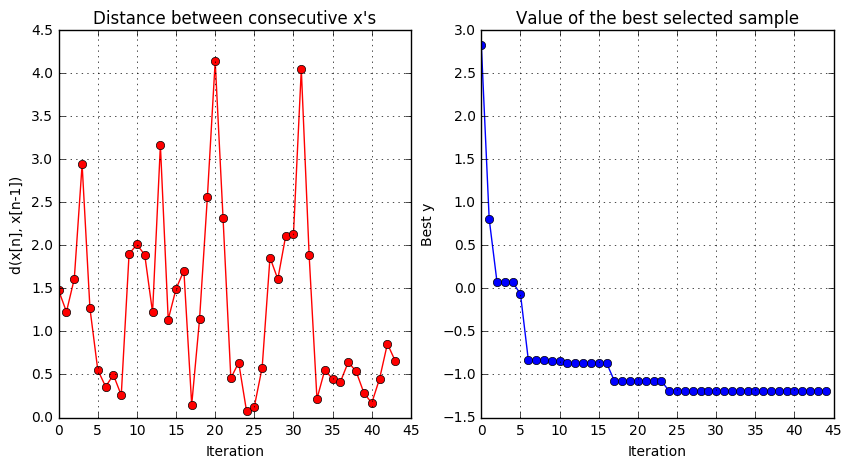

In [22]:
myBopt2D.plot_convergence()